In [197]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import joblib
import os 
import shutil
import pickle
from time import time

# Modelling

# 1 Preparation
Prepare both direction 1 and 2 csvs for modelling

Read in files for direction 1 and 2

In [198]:
df_dir_1 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/cleaned/feature_pairwise_cleaned_dir1.csv')
df_dir_2 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/cleaned/feature_pairwise_cleaned_dir2.csv')


Print some descriptors of the data

In [199]:
print("The shape of the direction 1 dataframe is:", df_dir_1.shape)
print("The shape of the direction 2 dataframe is:", df_dir_2.shape)


The shape of the direction 1 dataframe is: (937718, 10)
The shape of the direction 2 dataframe is: (933567, 9)


In [200]:
print("The datatypes in the direction 1 dataframe is:")
print(df_dir_1.dtypes)
print("The datatypes in the direction 2 dataframe is:")
print(df_dir_2.dtypes)


The datatypes in the direction 1 dataframe is:
LINEID              object
PLANNEDTIME_DEP    float64
temp               float64
humidity             int64
wind_speed         float64
weather_id           int64
TRIPTIME           float64
WEEKDAY              int64
MONTH                int64
RUSHHOUR             int64
dtype: object
The datatypes in the direction 2 dataframe is:
LINEID              object
PLANNEDTIME_DEP    float64
humidity             int64
wind_speed         float64
weather_id           int64
TRIPTIME           float64
WEEKDAY              int64
MONTH                int64
RUSHHOUR             int64
dtype: object


Check for null values

In [201]:
print("The number of null values in the direction 1 dataframe is: ",
      str(df_dir_1.isna().sum()))
print("The number of null values in the direction 2 dataframe is: ",
      str(df_dir_2.isna().sum()))


The number of null values in the direction 1 dataframe is:  LINEID             0
PLANNEDTIME_DEP    0
temp               0
humidity           0
wind_speed         0
weather_id         0
TRIPTIME           0
WEEKDAY            0
MONTH              0
RUSHHOUR           0
dtype: int64
The number of null values in the direction 2 dataframe is:  LINEID             0
PLANNEDTIME_DEP    0
humidity           0
wind_speed         0
weather_id         0
TRIPTIME           0
WEEKDAY            0
MONTH              0
RUSHHOUR           0
dtype: int64


Viewing the above column names in each dataframe. Column names should be consistent throughout both direction 1 and 2 dataframes. This is to ensure both dataframes contain the same columns for simplicity when combining with the front-end for feature input.

We can see above that direction 1 differs to direction 2 where it has the column temp. I will remove temp from direction 1 so that both dataframes contain the same features. This will make connecting the model with the frontend to fetch the input variables much easier.

In [202]:
df_dir_1 = df_dir_1.drop(columns=['temp'], axis=1)


In [203]:
print("The columns in direction 1 dataframe are:")
print(df_dir_1.columns)

print("The columns in direction 2 dataframe are:")
print(df_dir_2.columns)


The columns in direction 1 dataframe are:
Index(['LINEID', 'PLANNEDTIME_DEP', 'humidity', 'wind_speed', 'weather_id',
       'TRIPTIME', 'WEEKDAY', 'MONTH', 'RUSHHOUR'],
      dtype='object')
The columns in direction 2 dataframe are:
Index(['LINEID', 'PLANNEDTIME_DEP', 'humidity', 'wind_speed', 'weather_id',
       'TRIPTIME', 'WEEKDAY', 'MONTH', 'RUSHHOUR'],
      dtype='object')


Remove additional outliers

In [204]:
def remove_outliers(df_dir):

    lines_dir = sorted(list(df_dir['LINEID'].unique()))

    for line in lines_dir:
        # print number of rows in dataframe
        print("Number of rows remaining in dataframe:", str(df_dir.shape[0]))

        df_dir.reset_index(drop=True, inplace=True)
        print("Now doing line", str(line))

        # select all rows with the current line id
        df_selected_line = df_dir.loc[df_dir['LINEID'] == line]

        # get zscores
        line_zscores = np.abs(stats.zscore(df_selected_line['TRIPTIME']))

        # get rows above and below threshold
        rows_above_threshold = np.where(line_zscores > 3)
        rows_below_threshold = np.where(line_zscores < -3)
        # print number of rows
        print("There are", str(len(rows_above_threshold[0])), "row(s) above the threshold, and", str(len(rows_below_threshold[0])), "row(s) below \
               the threshold. ", str(len(rows_above_threshold[0])+len(rows_below_threshold[0])), "row(s) will be dropped from the dataframe")

        # convert to numpy array
        rows_above_threshold = np.asarray(rows_above_threshold)
        rows_below_threshold = np.asarray(rows_below_threshold)

        # drop rows outside of threshold
        df_dir = df_dir.drop(rows_above_threshold.flatten(), axis=0)
        df_dir = df_dir.drop(rows_below_threshold.flatten(), axis=0)
    return df_dir


In [205]:
df_dir_1.shape


(937718, 9)

In [206]:
df_dir_1 = remove_outliers(df_dir_1)


Number of rows remaining in dataframe: 937718
Now doing line 1
There are 16 row(s) above the threshold, and 0 row(s) below                the threshold.  16 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 937702
Now doing line 102
There are 57 row(s) above the threshold, and 0 row(s) below                the threshold.  57 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 937645
Now doing line 104
There are 32 row(s) above the threshold, and 0 row(s) below                the threshold.  32 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 937613
Now doing line 11
There are 335 row(s) above the threshold, and 0 row(s) below                the threshold.  335 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 937278
Now doing line 111
There are 7 row(s) above the threshold, and 0 row(s) below                the threshold.  7 row(s) will be dropped from the datafram

In [207]:
df_dir_2 = remove_outliers(df_dir_2)


Number of rows remaining in dataframe: 933567
Now doing line 1
There are 59 row(s) above the threshold, and 0 row(s) below                the threshold.  59 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 933508
Now doing line 102
There are 104 row(s) above the threshold, and 0 row(s) below                the threshold.  104 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 933404
Now doing line 104
There are 51 row(s) above the threshold, and 0 row(s) below                the threshold.  51 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 933353
Now doing line 11
There are 82 row(s) above the threshold, and 0 row(s) below                the threshold.  82 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 933271
Now doing line 111
There are 186 row(s) above the threshold, and 0 row(s) below                the threshold.  186 row(s) will be dropped from the data

In [208]:
df_dir_1.to_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir1.csv', index=False)
df_dir_2.to_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir2.csv', index=False)


# 2 Create Functions

## 2.1 Test-train-split

Set up test-train-split for modelling

In [41]:
def get_split(df_line):

    # shuffle data frame code from 'sample_solution_COMP47350_Task2_PredictiveModeling_Evaluation_CreditRiskPrediction.ipynb'
    # randomly generate sequence based on dataframe index and set to be new index
    df_line.set_index(np.random.permutation(df_line.index))
    # sort the resulting random index
    df_line.sort_index(inplace=True)

    # drop unneeded columns
    df_line.drop(columns=['LINEID'], inplace=True)

    X = df_line.drop(columns=["TRIPTIME"], axis=1)
    y = pd.DataFrame(df_line['TRIPTIME'])

    # do test train split
    # Split the dataset into two datasets, 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.35, random_state=1)

    return X_train, y_train, X_test, y_test


In [367]:
def train_test_dicts(df_dir):
    # create directory with all the lines of a direction
    lines_dir = sorted(list(df_dir['LINEID'].unique()))

    # Make dictionaries where the keys will store the training and test dataframes for each line
    # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
    X_train_dict = {}
    y_train_dict = {}
    X_test_dict = {}
    y_test_dict = {}

    # list to append low value samples
    lines_to_drop = []

    # iterate through lines
    for line in lines_dir:

        # dataframe containing only rows with current lineid
        df_line = df_dir.loc[df_dir['LINEID'] == line]

        # check for df with low values (where accurate predictions will not be possible as any one value will have too much influence on the overall model outcome)
        if df_line.shape[0] < 5:
            print('Not enough values for line', str(line))
            lines_to_drop.append(line)

        else:
            # get train test split
            split = get_split(df_line)

            # assign function return values to dicts
            X_train_dict[line] = split[0]
            y_train_dict[line] = split[1]
            X_test_dict[line] = split[2]
            y_test_dict[line] = split[3]

            # reset indexes so each line will adhere to the correct dataframe
            X_train_dict[line].reset_index(drop=True, inplace=True)
            y_train_dict[line].reset_index(drop=True, inplace=True)
            X_test_dict[line].reset_index(drop=True, inplace=True)
            y_test_dict[line].reset_index(drop=True, inplace=True)

    # https://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another
    lines_dir = [x for x in lines_dir if x not in lines_to_drop]

    return lines_dir, X_train_dict, y_train_dict, X_test_dict, y_test_dict


## 2.2 Linear Regression

Create a pickle file containing the prediction model for each line.

In [78]:
def get_lr_model_dict(direction, lines_dir, X_train_dict, y_train_dict):

    lr_model_dict = {}

    for line in lines_dir:
        print(f'Line {line}')

        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]

        lr = LinearRegression()
        lr_model_dict[line] = lr.fit(X_train, y_train)

        # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs
        dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/linreg/joblibfiles/line_{line}_model/dir{direction}'
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

        # save the model to a joblib file
        filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/linreg/joblibfiles/line_{line}_model/dir{direction}/line_{line}_lr.joblib'
        joblib.dump(lr_model_dict[line], open(filename, 'wb'))

    return lr_model_dict


Print some metrics evaluating the prediciton models performance.

In [79]:
def get_lr_metric_lists(direction, lines_dir, lr_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    # sum for averages
    train_mae_sum = 0
    train_mape_sum = 0
    train_rmse_sum = 0
    train_r2_sum = 0

    test_mae_sum = 0
    test_mape_sum = 0
    test_rsme_sum = 0
    test_r2_sum = 0

    train_metric_list = []
    test_metric_list = []

    for line in lines_dir:
        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        # training data
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
        # test data
        X_test = X_test_dict[line]
        y_test = y_test_dict[line]
        lr = lr_model_dict[line]

        lr_predictions_train = list(lr.predict(X_train))
        lr_predictions_test = list(lr.predict(X_test))

        # choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
        # https://towardsdatascience.com/random-forest-regression-5f605132d19d
        train_mae = metrics.mean_absolute_error(y_train, lr_predictions_train)
        train_mape = metrics.mean_absolute_percentage_error(
            y_train, lr_predictions_train)
        train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
                                                          lr_predictions_train))
        train_r2 = metrics.r2_score(
            y_train, lr_predictions_train)

        test_mae = metrics.mean_absolute_error(y_test, lr_predictions_test)
        test_mape = metrics.mean_absolute_percentage_error(
            y_test, lr_predictions_test)
        test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
                                                         lr_predictions_test))
        test_r2 = metrics.r2_score(y_test, lr_predictions_test)

        print(f"Test MAE for line {line}: {test_mae}")
        print(f"Test MAPE for line {line}: {test_mape}")

        with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/linreg/joblibfiles/line_{line}_model/dir{direction}/line_{line}_lr_metrics.csv', 'w') as file:
            file.write(f'\nTrain metrics for line {line}:'
                       f'\nMAE: {round(train_mae, 5)}' +
                       f'\nMAPE: {round(train_mape,5)}' +
                       f'\nMSE: {round(train_rmse,5)}' +
                       f'\nR2: {round(train_r2,5)}' +
                       f'\nTest metrics for line {line}:'
                       f'\nMAE: {round(test_mae,5)}' +
                       f'\nMAPE: {round(test_mape,5)}' +
                       f'\nMSE: {round(test_rmse,5)}' +
                       f'\nR2: {round(test_r2,5)}')

        # sum for averages
        train_mae_sum += train_mae
        train_mape_sum += train_mape
        train_rmse_sum += train_rmse
        train_r2_sum += train_r2

        test_mae_sum += test_mae
        test_mape_sum += test_mape
        test_rsme_sum += test_rmse
        test_r2_sum += test_r2

    train_metric_list.append(
        [train_mae_sum, train_mape_sum, train_rmse_sum, train_r2_sum])
    test_metric_list.append(
        [test_mae_sum, test_mape_sum, train_rmse_sum, test_r2_sum])

    return train_metric_list, test_metric_list


## 2.3 Random Forest
The random forest model works on the same test-train-splits as above. This next cell creates a prediction model for each line and dumps the model into a pickle file. Improved through https://www.keboola.com/blog/random-forest-regression

In [80]:
def get_rfr_model_dict(direction, lines_dir, X_train_dict, y_train_dict):

    rf_model_dict = {}

    for line in lines_dir:
        print(f'Line {line}')

        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]

        rfr = RandomForestRegressor(
            oob_score=True, random_state=1, n_estimators=25, max_depth=50)
        rf_model_dict[line] = rfr.fit(X_train, y_train)

        # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

        dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/picklefiles/line_{line}_model/dir{direction}'
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

        # save the model to a joblib file
        filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/picklefiles/line_{line}_model/dir{direction}/line_{line}_rfr.pkl'
        pickle.dump(rf_model_dict[line], open(filename, 'wb'))
    return rf_model_dict


Print metrics for each line into accompanying files outling the prediction model's performance.

In [81]:
def get_rf_metric_lists(direction, lines_dir, rf_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    # sum for averages
    train_mae_sum = 0
    train_mape_sum = 0
    train_rmse_sum = 0
    train_r2_sum = 0

    test_mae_sum = 0
    test_mape_sum = 0
    test_rmse_sum = 0
    test_r2_sum = 0

    train_metric_list = []
    test_metric_list = []

    for line in lines_dir:
        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        # training data
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
        # test data
        X_test = X_test_dict[line]
        y_test = y_test_dict[line]
        rfr = rf_model_dict[line]

        rfr_predictions_train = list(rfr.predict(X_train))
        rfr_predictions_test = list(rfr.predict(X_test))

        # choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
        # https://towardsdatascience.com/random-forest-regression-5f605132d19d
        train_mae = metrics.mean_absolute_error(y_train, rfr_predictions_train)
        train_mape = metrics.mean_absolute_percentage_error(
            y_train, rfr_predictions_train)
        train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
                                                          rfr_predictions_train))
        train_r2 = metrics.r2_score(
            y_train, rfr_predictions_train)

        test_mae = metrics.mean_absolute_error(y_test, rfr_predictions_test)
        test_mape = metrics.mean_absolute_percentage_error(
            y_test, rfr_predictions_test)
        test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
                                                         rfr_predictions_test))
        test_r2 = metrics.r2_score(y_test, rfr_predictions_test)

        print(f"Test MAE for line {line}: {round(test_mae,5)}")
        print(f"Test MAPE for line {line}: {round(test_mape,5)}")

        with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/picklefiles/line_{line}_model/dir{direction}/line_{line}_rfr_metrics.csv', 'w') as file:
            file.write(f'\nTrain metrics for line {line}:'
                       f'\nMAE: {round(train_mae, 5)}' +
                       f'\nMAPE: {round(train_mape,5)}' +
                       f'\nMSE: {round(train_rmse,5)}' +
                       f'\nR2: {round(train_r2,5)}' +
                       f'\nTest metrics for line {line}:'
                       f'\nMAE: {round(test_mae,5)}' +
                       f'\nMAPE: {round(test_mape,5)}' +
                       f'\nMSE: {round(test_rmse,5)}' +
                       f'\nR2: {round(test_r2,5)}')

        # sum for averages
        train_mae_sum += train_mae
        train_mape_sum += train_mape
        train_rmse_sum += train_rmse
        train_r2_sum += train_r2

        test_mae_sum += test_mae
        test_mape_sum += test_mape
        test_rmse_sum += test_rmse
        test_r2_sum += test_r2

    train_metric_list.append(
        [train_mae_sum, train_mape_sum, train_rmse_sum, train_r2_sum])
    test_metric_list.append(
        [test_mae_sum, test_mape_sum, test_rmse_sum, test_r2_sum])

    return train_metric_list, test_metric_list


## 2.4 Nearest Neighbour Regression
We have already determined the Random Forest Regressor to have a mean actual error score of 349.35 seconds and a mean actual percentage error score of 7.6%. To determine if our model can improve, we will now use a K Nearest Neighbour modelling algorithm on our data.

In [82]:
def get_knn_model_dict(direction, lines_dir, X_train_dict, y_train_dict):

    knn_model_dict = {}

    for line in lines_dir:
        print(f'Line {line}')

        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]

        k = 15

        knn = KNeighborsRegressor(n_neighbors=k)
        knn_model_dict[line] = knn.fit(X_train, y_train)

        # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

        dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/knn/joblibfiles/line_{line}_model/dir{direction}'
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

        # save the model to a joblib file
        filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/knn/joblibfiles/line_{line}_model/dir{direction}/line_{line}_knn.joblib'
        joblib.dump(knn_model_dict[line], open(filename, 'wb'))

    return knn_model_dict


Print some metrics evaluating the prediciton models performance.

In [83]:
def get_knn_metric_lists(direction, lines_dir, knn_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    # sum for averages
    train_mae_sum = 0
    train_mape_sum = 0
    train_rmse_sum = 0
    train_r2_sum = 0

    test_mae_sum = 0
    test_mape_sum = 0
    test_rmse_sum = 0
    test_r2_sum = 0

    train_metric_list = []
    test_metric_list = []

    for line in lines_dir:

        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        # training data
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
        # test data
        X_test = X_test_dict[line]
        y_test = y_test_dict[line]
        knn = knn_model_dict[line]

        knn_predictions_train = list(knn.predict(X_train))
        knn_predictions_test = list(knn.predict(X_test))
        # https://towardsdatascience.com/random-forest-regression-5f605132d19d
        # should be as close to 0 as possible (percentage error)
        train_mae = metrics.mean_absolute_error(y_train, knn_predictions_train)
        train_mape = metrics.mean_absolute_percentage_error(
            y_train, knn_predictions_train)
        train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
                                                          knn_predictions_train))
        train_r2 = metrics.r2_score(
            y_train, knn_predictions_train)

        test_mae = metrics.mean_absolute_error(y_test, knn_predictions_test)
        test_mape = metrics.mean_absolute_percentage_error(
            y_test, knn_predictions_test)
        test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
                                                         knn_predictions_test))
        test_r2 = metrics.r2_score(y_test, knn_predictions_test)

        print(f"Test MAE for line {line}: {round(test_mae,5)}")
        print(f"Test MAPE for line {line}: {round(test_mape,5)}")

        with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/knn/joblibfiles/line_{line}_model/dir{direction}/line_{line}_knn_metrics.csv', 'w') as file:
            file.write(f'\nTrain metrics for line {line}:'
                       f'\nMAE: {round(train_mae, 5)}' +
                       f'\nMAPE: {round(train_mape,5)}' +
                       f'\nMSE: {round(train_rmse,5)}' +
                       f'\nR2: {round(train_r2,5)}' +
                       f'\nTest metrics for line {line}:'
                       f'\nMAE: {round(test_mae,5)}' +
                       f'\nMAPE: {round(test_mape,5)}' +
                       f'\nMSE: {round(test_rmse,5)}' +
                       f'\nR2: {round(test_r2,5)}')
        # sum for averages
        train_mae_sum += train_mae
        train_mape_sum += train_mape
        train_rmse_sum += train_rmse
        train_r2_sum += train_r2

        test_mae_sum += test_mae
        test_mape_sum += test_mape
        test_rmse_sum += test_rmse
        test_r2_sum += test_r2

    train_metric_list.append(
        [train_mae_sum, train_mape_sum, train_rmse_sum, train_r2_sum])
    test_metric_list.append(
        [test_mae_sum, test_mape_sum, test_rmse_sum, test_r2_sum])

    return train_metric_list, test_metric_list


## 2.5 Print metrics
Print the average score for each metric:


In [84]:
def print_metrics(lines_dir, train_metric_list, test_metric_list):
    print("============Train metrics=============")
    print("Mean MAE:", str(round(train_metric_list[0]/len(lines_dir), 5)))
    print("Mean MAPE:", str(round(train_metric_list[1]/len(lines_dir), 5)))
    print("Mean RMSE:", str(round(train_metric_list[2]/len(lines_dir), 5)))
    print("Mean R2:", str(round(train_metric_list[3]/len(lines_dir), 5)))

    print("============Test metrics=============")
    print("Mean MAE:", str(round(test_metric_list[0]/len(lines_dir), 5)))
    print("Mean MAPE:", str(round(test_metric_list[1]/len(lines_dir), 5)))
    print("Mean RMSE:", str(round(test_metric_list[2]/len(lines_dir), 5)))
    print("Mean R2:", str(round(test_metric_list[3]/len(lines_dir), 5)))


# 3 Direction 1
When tried first on a linear regression model, we were receiving low accuracy with $r^2$ values below 0.2. We then switched to a Random Forest Regressor (RFR) model, which was proving to be a better fit for the data.

We began the RFR with all features (both medium and high information gain), and omitted features step by step in order to find the highest performing model that would give the most accuracy. Below is the code for this model.

## 3.1 Run the algorithm

In [244]:
df_dir_1 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir1.csv')

Drop features negatively impacting model performance:
* On the first run, weather_id was the lowest feature by importance. I changed this to dummy variables to see if this made a difference. The performance of this feature did not improve.
* We also checked for features which cumulatively contribute to 95% of the importance of the outcome of the model. This was shown to be plannedtime_dep, rush hour, weekday, wind_speed, humidity and month. weather_id was therefore dropped from the model.

Code for creating dummy variables from https://www.codegrepper.com/code-examples/python/append+a+set+of+dummies+to+dataframe

In [327]:
df_dir_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928062 entries, 0 to 928061
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   LINEID           928062 non-null  object 
 1   PLANNEDTIME_DEP  928062 non-null  float64
 2   humidity         928062 non-null  int64  
 3   wind_speed       928062 non-null  float64
 4   TRIPTIME         928062 non-null  float64
 5   WEEKDAY          928062 non-null  int64  
 6   MONTH            928062 non-null  int64  
 7   RUSHHOUR         928062 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 56.6+ MB


In [267]:
# dummies = pd.get_dummies(df_dir_1['weather_id'], drop_first=True)
# df_dir_1 = pd.concat([df_dir_1.drop(['weather_id'],axis=1), dummies],axis=1)

In [268]:
df_dir_1 = df_dir_1.drop(columns=['weather_id'])

In [269]:
df_dir_1

,LINEID,PLANNEDTIME_DEP,humidity,wind_speed,TRIPTIME,WEEKDAY,MONTH,RUSHHOUR
0,66B,82800.0,87,7.2,2354.0,2,2,0
1,15,82800.0,87,7.2,3873.0,2,2,0
2,17A,82800.0,87,7.2,2393.0,2,2,0
3,184,85200.0,87,7.2,1920.0,2,2,0
4,39A,84600.0,87,7.2,1071.0,2,2,0
...,...,...,...,...,...,...,...,...
928057,65,20400.0,93,2.1,3632.0,5,5,0
928058,27,19800.0,93,2.1,3884.0,5,5,0
928059,77A,21300.0,93,2.1,3102.0,5,5,0
928060,65B,21000.0,93,2.1,2359.0,5,5,0


1. Set up test train split

In [270]:
return_func_1 = train_test_dicts(df_dir_1)

Not enough values for line 41D


We can see the line with less than 5 rows is 41D. We will therefore omit this line from modelling.

In [271]:
lines_dir = return_func_1[0]
X_train_dict = return_func_1[1]
y_train_dict = return_func_1[2]
X_test_dict = return_func_1[3]
y_test_dict = return_func_1[4]

### 3.1.1. Linear Regression

In [272]:
lr_model_dict = get_lr_model_dict(1, lines_dir, X_train_dict, y_train_dict)

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33E
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B


In [273]:
lr_metric_list = get_lr_metric_lists(
    1, lines_dir, lr_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)


Test MAE for line 1: 550.7197633109957
Test MAPE for line 1: 0.25886275166673883
Test MAE for line 102: 362.81690571608357
Test MAPE for line 102: 0.10399364896521966
Test MAE for line 104: 323.91498146383026
Test MAPE for line 104: 0.1318001998618543
Test MAE for line 11: 787.5377991591378
Test MAPE for line 11: 0.2591667051881821
Test MAE for line 111: 303.7267667855022
Test MAPE for line 111: 0.12409169250890376
Test MAE for line 114: 265.3848427423607
Test MAPE for line 114: 0.14725730353643407
Test MAE for line 116: 511.1930182754055
Test MAPE for line 116: 0.16038386989155162
Test MAE for line 120: 313.96706292163594
Test MAPE for line 120: 0.17192216114038567
Test MAE for line 122: 487.96795711874813
Test MAPE for line 122: 0.16512338739974666
Test MAE for line 123: 464.1701315782122
Test MAPE for line 123: 0.14398259788717854
Test MAE for line 13: 718.3635407711379
Test MAPE for line 13: 0.15617495541919177
Test MAE for line 130: 207.8519566108155
Test MAPE for line 130: 0.1157

In [274]:
lr_train_metric_list = lr_metric_list[0][0]
lr_test_metric_list = lr_metric_list[1][0]


In [275]:
print("LR")
print_metrics(lines_dir, lr_train_metric_list, lr_test_metric_list)


LR
============Train metrics=============
Mean MAE: 441.28228
Mean MAPE: 0.14324
Mean RMSE: 582.42328
Mean R2: 0.2329
============Test metrics=============
Mean MAE: 444.3989
Mean MAPE: 0.20799
Mean RMSE: 582.42328
Mean R2: 0.21579


### 3.1.2 Random Forest

In [276]:
rf_model_dict = get_rfr_model_dict(1, lines_dir, X_train_dict, y_train_dict)

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33E
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B


In [277]:
rf_metric_list = get_rf_metric_lists(
    1, lines_dir, rf_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)

Test MAE for line 1: 274.14989
Test MAPE for line 1: 0.10141
Test MAE for line 102: 295.31294
Test MAPE for line 102: 0.08309
Test MAE for line 104: 262.33631
Test MAPE for line 104: 0.10539
Test MAE for line 11: 233.99505
Test MAPE for line 11: 0.05198
Test MAE for line 111: 221.71128
Test MAPE for line 111: 0.08565
Test MAE for line 114: 206.10341
Test MAPE for line 114: 0.11164
Test MAE for line 116: 418.87135
Test MAPE for line 116: 0.12677
Test MAE for line 120: 252.51405
Test MAPE for line 120: 0.13325
Test MAE for line 122: 327.96588
Test MAPE for line 122: 0.08661
Test MAE for line 123: 327.13363
Test MAPE for line 123: 0.0936
Test MAE for line 13: 479.78895
Test MAPE for line 13: 0.08223
Test MAE for line 130: 159.30825
Test MAPE for line 130: 0.08779
Test MAE for line 14: 408.20881
Test MAPE for line 14: 0.08334
Test MAE for line 140: 287.47512
Test MAPE for line 140: 0.08024
Test MAE for line 142: 186.10515
Test MAPE for line 142: 0.08225
Test MAE for line 145: 427.29387
Tes

In [278]:
rf_train_metric_list = rf_metric_list[0][0]
rf_test_metric_list = rf_metric_list[1][0]

In [279]:
print("RFR")
print_metrics(lines_dir, rf_train_metric_list, rf_test_metric_list)


RFR
============Train metrics=============
Mean MAE: 128.95366
Mean MAPE: 0.04078
Mean RMSE: 187.04806
Mean R2: 0.90965
============Test metrics=============
Mean MAE: 332.48277
Mean MAPE: 0.16195
Mean RMSE: 459.75903
Mean R2: 0.44743


Code from https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

In [280]:
# Extract features and labels
features = df_dir_1.drop(columns=['TRIPTIME','LINEID'], axis = 1)
feature_list = list(features.columns)

In [281]:
# Get numerical feature importances
importances = list(rf_model_dict['46A'].feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: PLANNEDTIME_DEP      Importance: 0.63
Variable: RUSHHOUR             Importance: 0.09
Variable: humidity             Importance: 0.08
Variable: wind_speed           Importance: 0.08
Variable: WEEKDAY              Importance: 0.07
Variable: MONTH                Importance: 0.06


[None, None, None, None, None, None]

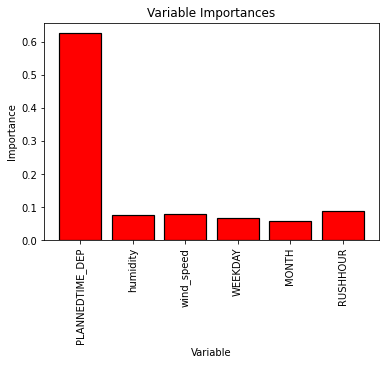

In [282]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

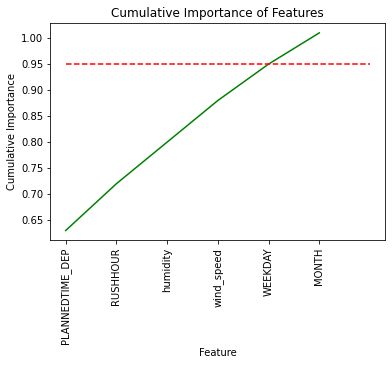

In [283]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Feature'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importance of Features');

In [284]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)


Number of features for 95% importance: 6


In [285]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:6]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
important_feature_names

['PLANNEDTIME_DEP', 'RUSHHOUR', 'humidity', 'wind_speed', 'WEEKDAY', 'MONTH']

### 3.1.3 KNN
Changed minimum number of rows to 15 in the train_test_dicts function before running KNN

In [293]:
return_func_1 = train_test_dicts(df_dir_1)

Not enough values for line 33E
Not enough values for line 41D


In [294]:
lines_dir = return_func_1[0]
X_train_dict = return_func_1[1]
y_train_dict = return_func_1[2]
X_test_dict = return_func_1[3]
y_test_dict = return_func_1[4]

In [295]:
knn_model_dict = get_knn_model_dict(1, lines_dir, X_train_dict, y_train_dict)


Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B
Line 7D
L

In [296]:
knn_metric_list = get_knn_metric_lists(
    1, lines_dir, knn_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)


Test MAE for line 1: 311.20236
Test MAPE for line 1: 0.11608
Test MAE for line 102: 312.99618
Test MAPE for line 102: 0.08895
Test MAE for line 104: 283.88388
Test MAPE for line 104: 0.11401
Test MAE for line 11: 403.74988
Test MAPE for line 11: 0.08978
Test MAE for line 111: 221.25886
Test MAPE for line 111: 0.08488
Test MAE for line 114: 235.31766
Test MAPE for line 114: 0.13006
Test MAE for line 116: 560.85946
Test MAPE for line 116: 0.1731
Test MAE for line 120: 241.73687
Test MAPE for line 120: 0.13026
Test MAE for line 122: 364.75807
Test MAPE for line 122: 0.09832
Test MAE for line 123: 345.22834
Test MAPE for line 123: 0.09911
Test MAE for line 13: 490.01723
Test MAPE for line 13: 0.08386
Test MAE for line 130: 158.88646
Test MAPE for line 130: 0.08733
Test MAE for line 14: 464.83433
Test MAPE for line 14: 0.09626
Test MAE for line 140: 316.54434
Test MAPE for line 140: 0.08841
Test MAE for line 142: 237.56848
Test MAPE for line 142: 0.09262
Test MAE for line 145: 461.22441
Tes

3. Print results

In [297]:
knn_train_metric_list = knn_metric_list[0][0]
knn_test_metric_list = knn_metric_list[1][0]

In [299]:
print("KNN")
print_metrics(lines_dir, knn_train_metric_list, knn_test_metric_list)

KNN
============Train metrics=============
Mean MAE: 325.61037
Mean MAPE: 0.10101
Mean RMSE: 447.78681
Mean R2: 0.50179
============Test metrics=============
Mean MAE: 349.2813
Mean MAPE: 0.17942
Mean RMSE: 478.32591
Mean R2: 0.43012


- tried using sqrt of the number of samples in each model, worsened model
https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb
- tried using 15 (optimum according to graph of full dataframe), worsened model

Print the order of the most influential features on the model.

In [300]:
line_46A = df_dir_1.loc[df_dir_1['LINEID'] == '46A']


In [301]:
split_46A = get_split(line_46A)


In [302]:
X_train = split_46A[0]
y_train = split_46A[1]
X_test = split_46A[2]
y_test = split_46A[3]


Determining optimal k value
https://www.geeksforgeeks.org/ml-implementation-of-knn-classifier-using-sklearn/

In [303]:
K = []
training = []
test = []
scores = {}

for k in range(10, 200, 5):
    clf = KNeighborsRegressor(n_neighbors=k)
    clf.fit(X_train, y_train)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)

    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]


In [304]:
for keys, values in scores.items():
    print(keys, ':', values)


10 : [0.692180827880365, 0.6268728011621698]
15 : [0.6759866633190179, 0.6324612684119871]
20 : [0.6662862675351444, 0.6338446370343358]
25 : [0.6601744270555076, 0.6353210173513879]
30 : [0.6548262523394106, 0.6344253299639183]
35 : [0.6497766492339427, 0.6310001398648285]
40 : [0.6451858132139465, 0.6282160582499232]
45 : [0.6402710243902332, 0.624861943070695]
50 : [0.6363596568547567, 0.6215973396136709]
55 : [0.6328333050674089, 0.6192160089739454]
60 : [0.6291129371716471, 0.6166654406900944]
65 : [0.6254883343708912, 0.6133635349565736]
70 : [0.621733256988809, 0.610632879201195]
75 : [0.617627984121067, 0.6071276767258132]
80 : [0.6133928757293479, 0.6032271171996797]
85 : [0.6091527137989099, 0.5998490749226789]
90 : [0.6050066958930224, 0.5957517335864781]
95 : [0.6004593296993102, 0.5919483520903857]
100 : [0.5962467252614622, 0.5878768829826913]
105 : [0.5921628406551875, 0.5833556892591324]
110 : [0.5876110049050899, 0.578891624059211]
115 : [0.5829292380005486, 0.57435264

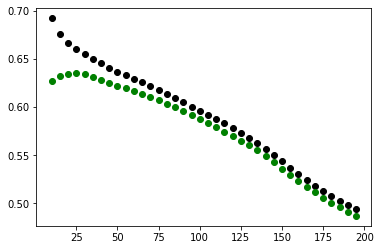

In [306]:
plt.scatter(K, training, color='k')
plt.scatter(K, test, color='g')
plt.show()


The above graph and results show that the optimal k value for the 46A line is around 25.


In [308]:
knn_46A = KNeighborsRegressor(n_neighbors=25)

In [309]:
knn_46A.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=25)

In [310]:
train_preds = knn_46A.predict(X_train)
train_preds


array([[5193.12],
       [4731.64],
       [3728.8 ],
       ...,
       [4054.08],
       [4406.2 ],
       [4549.6 ]])

In [311]:
test_preds = knn_46A.predict(X_test)


In [312]:
X_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12123 entries, 116945 to 464433
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PLANNEDTIME_DEP  12123 non-null  float64
 1   humidity         12123 non-null  int64  
 2   wind_speed       12123 non-null  float64
 3   WEEKDAY          12123 non-null  int64  
 4   MONTH            12123 non-null  int64  
 5   RUSHHOUR         12123 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 663.0 KB


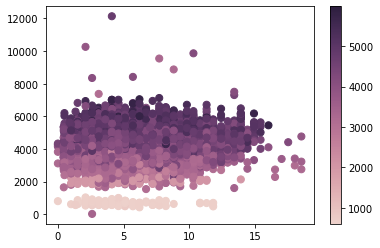

In [313]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
    X_test.iloc[:, 2], y_test.iloc[:, 0], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()


## 3.2 Optimising the Random Forest model

Using the 46A line as this is the largest file, I will try to optimise the random forest regressor model

### 3.2.1 Pickle vs Joblib

In [317]:
line = '46A'
# dataframe containing only rows with current lineid
df_line = df_dir_1[df_dir_1['LINEID'] == line]

# randomly generate sequence based on dataframe index and set to be new index
df_line.set_index(np.random.permutation(df_line.index))
# sort the resulting random index
df_line.sort_index(inplace=True)

# drop unneeded columns
df_line.drop(columns=['LINEID'], inplace=True)

X = df_line.drop(columns=["TRIPTIME"], axis=1)
y = pd.DataFrame(df_line['TRIPTIME'])
# do test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

rfr = RandomForestRegressor(oob_score=True, random_state=1)
result = rfr.fit(X_train, y_train)

filenamej = '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/testing/joblib.joblib'
joblib.dump(result, open(filenamej, 'wb'))
filenamep = '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/testing/pickle.pkl'
pickle.dump(result, open(filenamep, 'wb'))

In [358]:
t1 = time()
filenamej = '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/testing/joblib.joblib'
model = joblib.load(filenamej) 
# order of features is ['PLANNEDTIME_DEP','RUSHHOUR','humidity','wind_speed','WEEKDAY','MONTH']
print(model.predict([[19800, 0, 75, 5.1, 1, 1]]))
print(time() -t1)

[4098.21]
0.3929328918457031


In [360]:
t2 = time()
filenamep = '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/testing/pickle.pkl'
model = pickle.load(open(filenamep, 'rb')) 
# order of features is ['PLANNEDTIME_DEP','RUSHHOUR','humidity','wind_speed','WEEKDAY','MONTH']
print(model.predict([[19800, 0, 75, 5.1, 1, 1]]))
print(time() -t2)

[4098.21]
0.29845666885375977


Pickle is much faster so we will use this as the file type.

### 3.2.2 Choosing the optimum test train split
To do this I will first get the rows with the highest number of lines from s4_feature_pairwise_interactions.ipynb and run them through the following algorithm where I will collect the test scores for each line while setting the test train split to different ratios. Finally I will plot the data to determine the optimum test train split.

In [361]:
line = '46A'
# dataframe containing only rows with current lineid
df_line = df_dir_1[df_dir_1['LINEID'] == line]

# randomly generate sequence based on dataframe index and set to be new index
df_line.set_index(np.random.permutation(df_line.index))
# sort the resulting random index
df_line.sort_index(inplace=True)

# drop unneeded columns
df_line.drop(columns=['LINEID'], inplace=True)

X = df_line.drop(columns=["TRIPTIME"], axis=1)
y = pd.DataFrame(df_line['TRIPTIME'])

# find best test train split
i=0.1
score= []
I = []
while i <= 0.5:
    # do test train split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=i, random_state=1)

    rfr = RandomForestRegressor(oob_score=True, random_state=1)
    rfr.fit(X_train, y_train)
    test_score = rfr.score(X_test, y_test)

    score.append(test_score)
    I.append(i)

    i+=0.05

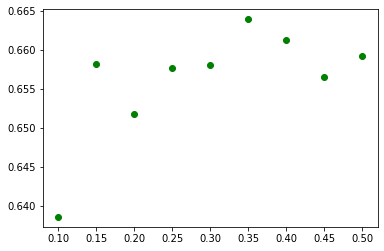

In [362]:
plt.scatter(I, score, color='g')
plt.show()


The above graphs show that the model performs best on the test set when the test set has 35% of the data.

### 3.2.3 Finding the optimum max_depth and n_estimators
Setting the test set to 0.35, I will try to find the optimum max_depth and n_estimators.

In [364]:
line = '46A'
# dataframe containing only rows with current lineid
df_line = df_dir_1[df_dir_1['LINEID'] == line]

# randomly generate sequence based on dataframe index and set to be new index
df_line.set_index(np.random.permutation(df_line.index))
# sort the resulting random index
df_line.sort_index(inplace=True)

# drop unneeded columns
df_line.drop(columns=['LINEID'], inplace=True)

X = df_line.drop(columns=["TRIPTIME"], axis=1)
y = pd.DataFrame(df_line['TRIPTIME'])

# do test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=1)

maxdepth = 50
estimators = 25
rfr = RandomForestRegressor(
    oob_score=True, random_state=1, max_depth=maxdepth, n_estimators=estimators)
result = rfr.fit(X_train, y_train)

# save the model to a joblib file
filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/testing/mdepth_{maxdepth}_est_{estimators}.joblib'
joblib.dump(result, open(filename, 'wb'))


In [365]:
rfr_predictions_train = list(rfr.predict(X_train))
rfr_predictions_test = list(rfr.predict(X_test))

# choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
# https://towardsdatascience.com/random-forest-regression-5f605132d19d
train_mae = metrics.mean_absolute_error(y_train, rfr_predictions_train)
train_mape = metrics.mean_absolute_percentage_error(
    y_train, rfr_predictions_train)
train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
                                                  rfr_predictions_train))
train_r2 = metrics.r2_score(y_train, rfr_predictions_train)

test_mae = metrics.mean_absolute_error(y_test, rfr_predictions_test)
test_mape = metrics.mean_absolute_percentage_error(
    y_test, rfr_predictions_test)
test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
                                                 rfr_predictions_test))
test_r2 = metrics.r2_score(y_test, rfr_predictions_test)
with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/testing/mdepth_{maxdepth}_est_{estimators}_metrics.csv', 'w') as file:
    file.write(f'\nTrain metrics for line {line}:'
               f'\nMAE: {train_mae}' +
               f'\nMAPE: {train_mape}' +
               f'\nRMSE: {train_rmse}' +
               f'\nR2: {train_r2}' +
               f'\nTest metrics for line {line}:'
               f'\nMAE: {test_mae}' +
               f'\nMAPE: {test_mape}' +
               f'\nRMSE: {test_rmse}' +
               f'\nR2: {test_r2}')


In [366]:
print(f"Max depth: {maxdepth}, n_estimators: {estimators}\n")
print("============Train metrics=============")
print("MAE:", train_mae)
print("MAPE:", train_mape)
print("RMSE:", train_rmse)
print("R2:", train_r2)

print("============Test metrics=============")
print("MAE:", test_mae)
print("MAPE:", test_mape)
print("RMSE:", test_rmse)
print("R2:", test_r2)


Max depth: 50, n_estimators: 25

============Train metrics=============
MAE: 145.32216654081347
MAPE: 0.034615016638061845
RMSE: 208.026107801937
R2: 0.9430810225883444
============Test metrics=============
MAE: 379.19348727919777
MAPE: 0.10538476071500452
RMSE: 515.9662893321039
R2: 0.6555468567726007


- Optimal max_depth = 50, n_estimators=25, file size 45.5MB

# 4 Direction 2
Remembering from <i>feature_pairwise_interactions.ipynb</i> the following:
* categorical_med_info_gain = ['weather_id']
* categorical_high_info_gain = ['HOUR','WEEKDAY','MONTH']

## 4.1 Test-train-split

In [368]:
df_dir_2 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir2.csv')

In [370]:
df_dir_2.columns

Index(['LINEID', 'PLANNEDTIME_DEP', 'humidity', 'wind_speed', 'weather_id',
       'TRIPTIME', 'WEEKDAY', 'MONTH', 'RUSHHOUR'],
      dtype='object')

Began model creation for Direction 2 by dropping poor performing features from the dataframe as these feature were dropped from direction 1's modelling.

In [372]:
df_dir_2 = df_dir_2.drop(
    columns=['weather_id'])

Perform test-train-split

In [373]:
return_func_2 = train_test_dicts(df_dir_2)

In [374]:
lines_dir = return_func_2[0]
X_train_dict = return_func_2[1]
y_train_dict = return_func_2[2]
X_test_dict = return_func_2[3]
y_test_dict = return_func_2[4]

## 4.2 Run the Algorithm

### 4.2.1 Random Forest

In [375]:
rf_model_dict = get_rfr_model_dict(2, lines_dir, X_train_dict, y_train_dict)

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 118
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41A
Line 41B
Line 41C
Line 41D
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 46E
Line 47
Line 49
Line 51D
Line 51X
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 68X
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 7

In [376]:
rf_metric_list = get_rf_metric_lists(
    2, lines_dir, rf_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)

Test MAE for line 1: 303.91413
Test MAPE for line 1: 0.1089
Test MAE for line 102: 262.11993
Test MAPE for line 102: 0.07963
Test MAE for line 104: 310.47511
Test MAPE for line 104: 0.12827
Test MAE for line 11: 357.80663
Test MAPE for line 11: 0.08375
Test MAE for line 111: 392.34913
Test MAPE for line 111: 0.17508
Test MAE for line 114: 207.47161
Test MAPE for line 114: 0.11376
Test MAE for line 116: 680.70105
Test MAPE for line 116: 0.12231
Test MAE for line 118: 401.55915
Test MAPE for line 118: 0.10566
Test MAE for line 120: 164.22252
Test MAPE for line 120: 0.1019
Test MAE for line 122: 331.33245
Test MAPE for line 122: 0.08463
Test MAE for line 123: 327.93466
Test MAPE for line 123: 0.09274
Test MAE for line 13: 486.27575
Test MAPE for line 13: 0.0849
Test MAE for line 130: 198.6554
Test MAPE for line 130: 0.10832
Test MAE for line 14: 524.69075
Test MAPE for line 14: 0.14453
Test MAE for line 140: 460.51433
Test MAPE for line 140: 0.12059
Test MAE for line 142: 211.21516
Test M

In [377]:
rf_train_metric_list = rf_metric_list[0][0]
rf_test_metric_list = rf_metric_list[1][0]

In [378]:
print("RFR")
print_metrics(lines_dir, rf_train_metric_list, rf_test_metric_list)

RFR
============Train metrics=============
Mean MAE: 133.97443
Mean MAPE: 0.03856
Mean RMSE: 190.78401
Mean R2: 0.91631
============Test metrics=============
Mean MAE: 345.13094
Mean MAPE: 0.1077
Mean RMSE: 475.3023
Mean R2: 0.39694
